In [1]:
import getpass
import plotly.express as px
import plotly.io as pio
import time
import urllib.parse

# Allow charts to persist between notebook sessions.
pio.renderers.default='notebook'

In [2]:
edm_address = ""# getpass.getpass(prompt='EDM server address: ')
print(edm_address)
print('\nEDM login information')
edm_name = ""#getpass.getpass(prompt='Username: ')
edm_password = getpass.getpass(prompt='Password: ')
edm_password = urllib.parse.quote(edm_password)
%load_ext sql
%sql postgresql://$edm_name:$edm_password@$edm_address/edm
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False
print(edm_name, edm_password)
# Delete the credential variables for security purpose.
del edm_name, edm_password

sandpit-edm.awesense.com

EDM login information
Password: ········
PIMS-Batool 7UViT2gF


In [4]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pytz
import pandas as pd
from pulp import LpMinimize, LpProblem, LpVariable, lpSum
from prophet import Prophet
import plotly.express as px
import plotly.graph_objects as go

#GRID
#grid_id = 'awefice'
#grid_element_id = 'line_segment_57'
#end_date = '2023-01-01 00:00:00'
# Define grid and element IDs
grid_id = 'North Central Zone'
grid_element_id = '12373_hvmv'
end_date = '2023-01-01 00:00:00'

# Time
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').replace(microsecond=0, second=0, minute=0)
end_date = pytz.timezone('America/Vancouver').localize(end_date)

start_date = end_date - relativedelta(years=2)
timerange_years = f'[ {start_date} , {end_date} ]'

# SQL Query to aggregate at the phase level for the past two years
query_phases_years = f"""
SELECT EXTRACT(YEAR FROM tdss_c.timestamp) AS year,
       EXTRACT(MONTH FROM tdss_c.timestamp) AS month,
       ggd.phases,
       ROUND(CAST(SUM(tdss_c.value - COALESCE(tdss_p.value, 0)) AS NUMERIC), 2) as "total_kwh"
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
JOIN grid_element_data_source geds_c 
    ON geds_c.grid_element_id = ggd.grid_element_id 
        AND geds_c.type = 'CONSUMER' 
JOIN ts_data_source_select(geds_c.grid_element_data_source_id, 'kWh', '{timerange_years}') tdss_c 
    ON true 
LEFT JOIN grid_element_data_source geds_p 
    ON geds_p.grid_element_id = geds_c.grid_element_id 
        AND geds_p.type = 'PRODUCER' 
LEFT JOIN ts_data_source_select(geds_p.grid_element_data_source_id, 'kWh', '{timerange_years}') tdss_p 
    ON tdss_p.timestamp = tdss_c.timestamp 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY year, month, ggd.phases
ORDER BY year, month, ggd.phases;
"""

# Creat DataFrame
result_phases_years = %sql $query_phases_years
df_phases_years = result_phases_years.DataFrame()


df_phases_years.columns = [col.lower() for col in df_phases_years.columns]


print("Raw Historical Optimal Phase Load Data (Past Two Years):")
print(df_phases_years.head())


df_filtered = df_phases_years[(df_phases_years['phases'].isin(['A', 'B', 'C'])) & (df_phases_years['year'].isin([2021, 2022]))]
total_kwh_by_phase_year = df_filtered.groupby(['year', 'phases'])['total_kwh'].sum().reset_index()

print("Total kWh Load by Phase for the Years 2021 and 2022:")
print(total_kwh_by_phase_year)

# Function to calculate optimal loads
def calculate_optimal_loads(df):
    actual_loads = df.set_index('phases')['total_kwh'].astype(float)
    prob = LpProblem("PhaseBalance", LpMinimize)
    phase_loads = {phase: LpVariable(f"Load_{phase}", 0) for phase in actual_loads.index}
    abs_diff = {(phase, other_phase): LpVariable(f"AbsDiff_{phase}_{other_phase}", 0) 
                for phase in actual_loads.index for other_phase in actual_loads.index if phase != other_phase}
    prob += lpSum(abs_diff.values())
    total_load = actual_loads.sum()
    prob += lpSum(phase_loads.values()) == total_load
    average_load = total_load / len(actual_loads)
    for phase in actual_loads.index:
        prob += phase_loads[phase] <= average_load + 10 
        prob += phase_loads[phase] >= average_load - 10
    for phase in actual_loads.index:
        for other_phase in actual_loads.index:
            if phase != other_phase:
                prob += abs_diff[(phase, other_phase)] >= phase_loads[phase] - phase_loads[other_phase]
                prob += abs_diff[(phase, other_phase)] >= phase_loads[other_phase] - phase_loads[phase]
    prob.solve()
    optimal_loads = {phase: phase_loads[phase].value() for phase in phase_loads}
    return optimal_loads

# Calculate optimal loads for each year
optimal_loads_per_year = []
for year in [2021, 2022]:
    df_year = total_kwh_by_phase_year[total_kwh_by_phase_year['year'] == year]
    optimal_loads = calculate_optimal_loads(df_year)
    for phase, load in optimal_loads.items():
        optimal_loads_per_year.append({'year': year, 'phase': phase, 'optimal_load': load})

df_optimal_loads = pd.DataFrame(optimal_loads_per_year)
print("Optimal Loads for Each Year:")
print(df_optimal_loads)

# Step 3: Prepare the Data for Prophet (Predective Model)
df_optimal_loads['ds'] = pd.to_datetime(df_optimal_loads['year'].astype(str) + '-01-01')
df_optimal_loads.rename(columns={'optimal_load': 'y'}, inplace=True)

# Train the Model on two points
models = {}
for phase in df_optimal_loads['phase'].unique():
    phase_data = df_optimal_loads[df_optimal_loads['phase'] == phase]
    model = Prophet()
    model.fit(phase_data[['ds', 'y']])
    models[phase] = model

print("Models trained for each phase.")

# Forecast Future Values
future_forecasts = pd.DataFrame()
for phase, model in models.items():
    future = model.make_future_dataframe(periods=1, freq='YS')
    future['ds'] = future['ds'].dt.to_period('Y').dt.to_timestamp()
    forecast = model.predict(future)
    forecasted_optimal_loads = forecast[['ds', 'yhat']].tail(1)
    forecasted_optimal_loads['phase'] = phase
    future_forecasts = pd.concat([future_forecasts, forecasted_optimal_loads], ignore_index=True)

print("Forecasted Optimal Loads for the Next Year:")
print(future_forecasts)

# Visualization
fig = go.Figure()


for phase in df_optimal_loads['phase'].unique():
    phase_data = df_optimal_loads[df_optimal_loads['phase'] == phase]
    fig.add_trace(go.Scatter(
        x=phase_data['ds'],
        y=phase_data['y'],
        mode='lines+markers',
        name=f'Historical {phase}',
        line=dict(shape='linear'),
    ))


for phase in future_forecasts['phase'].unique():
    phase_forecast = future_forecasts[future_forecasts['phase'] == phase]
    fig.add_trace(go.Scatter(
        x=phase_forecast['ds'],
        y=phase_forecast['yhat'],
        mode='markers',
        name=f'Forecasted {phase}',
        marker=dict(size=10, symbol='circle'),
    ))


fig.update_layout(
    title='Historical and Forecasted Optimal Loads by Phase',
    xaxis_title='Date',
    yaxis_title='Optimal Load (kWh)',
    legend_title='Phase',
    template='plotly_white'
)

fig.show()


Raw Historical Optimal Phase Load Data (Past Two Years):
     year  month phases  total_kwh
0  2021.0    1.0      A  191518.17
1  2021.0    1.0      B  124706.93
2  2021.0    1.0      C   43545.14
3  2021.0    2.0      A  199349.10
4  2021.0    2.0      B  129659.92
Total kWh Load by Phase for the Years 2021 and 2022:
     year phases   total_kwh
0  2021.0      A  2603416.73
1  2021.0      B  1725382.00
2  2021.0      C   611535.79
3  2022.0      A  2631241.86
4  2022.0      B  1743374.24
5  2022.0      C   619265.78
Optimal Loads for Each Year:
   year phase  optimal_load
0  2021     A     1646778.2
1  2021     B     1646778.2
2  2021     C     1646778.2
3  2022     A     1664627.3
4  2022     B     1664627.3
5  2022     C     1664627.3


10:59:39 - cmdstanpy - INFO - Chain [1] start processing
10:59:41 - cmdstanpy - INFO - Chain [1] done processing
10:59:41 - cmdstanpy - INFO - Chain [1] start processing
10:59:43 - cmdstanpy - INFO - Chain [1] done processing
10:59:43 - cmdstanpy - INFO - Chain [1] start processing
10:59:44 - cmdstanpy - INFO - Chain [1] done processing


Models trained for each phase.
Forecasted Optimal Loads for the Next Year:
          ds          yhat phase
0 2023-01-01  1.682476e+06     A
1 2023-01-01  1.682476e+06     B
2 2023-01-01  1.682476e+06     C


C:\Users\Department of Math\Documents\GitHub\edm-app-examples\AwesenseEnv\Lib\site-packages\_plotly_utils\basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Past Year Loads:
  phases   total_kwh
0      C   583899.09
1      B  1654997.97
2      A  2501934.65


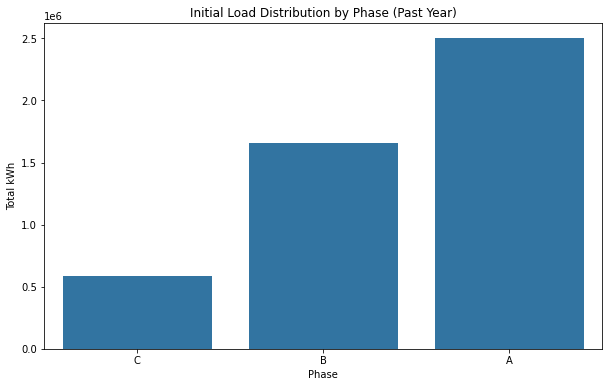

Meter Counts per Phase:
  phases  meter_count
0      C           40
1      B          110
2      A          166
Actual Loads:
 phases
C     583899.09
B    1654997.97
A    2501934.65
Name: total_kwh, dtype: float64
Optimal load for phase C: 1580277.2
Optimal load for phase B: 1580277.2
Optimal load for phase A: 1580277.2


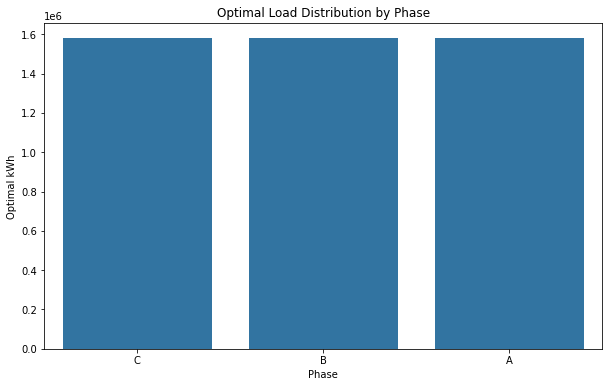

Load Differences:
 phases
C   -996378.11
B     74720.77
A    921657.45
dtype: float64
Meters Result:
   phases    meter_id  total_kwh
0      A  17Y124-3-3    6103.29
1      A    17FY28-2    6330.81
2      A   17Y160CZA    7215.66
3      A      17BY14    7251.37
4      A    17Y163-B    7294.23
5      A     17B1Y12    7318.71
6      A     17Y12-X    7350.11
7      A      17BY11    7516.69
8      A   17F1Y25-7    7581.09
9      A     17Y118X    7950.42
Reassign meter 17AY44-1ZA from phase B to phase C with load 37345.25
Reassign meter 17AY38 from phase B to phase C with load 36483.02
Reassign meter 17Y34-B from phase B to phase C with load 25463.71
Reassign meter 17BY3-1 from phase A to phase C with load 97235.02
Reassign meter 17Y172X from phase A to phase C with load 31459.91
Reassign meter 17FY19 from phase A to phase C with load 28711.86
Reassign meter 17Y125 from phase A to phase B with load 24609.94
Improvement: 513397.5399999998, Previous total diff: 1992756.3299999998, Current tot

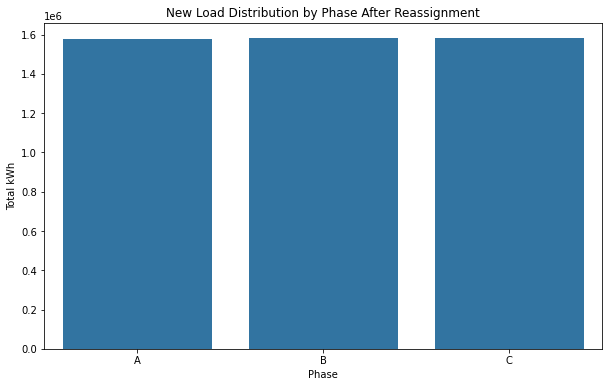

In [5]:
#YEARLY(2023)
from pulp import LpMinimize, LpProblem, LpVariable, lpSum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta

# GRID
grid_id = 'North Central Zone'
grid_element_id = '12373_hvmv'
end_date = '2024-01-01 00:00:00'

# TIME
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').replace(microsecond=0, second=0, minute=0)
end_date = pytz.timezone('America/Vancouver').localize(end_date)


past_year = end_date - relativedelta(years=1)
timerange_year = f'[ {past_year} , {end_date} ]'

# SQL Query to aggregate at the phase level for past year
query_phases_year = f"""
SELECT ggd.phases,
    ROUND(CAST(SUM(tdss_c.value - COALESCE(tdss_p.value, 0)) AS NUMERIC), 2) as "total_kWh"
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
JOIN grid_element_data_source geds_c 
    ON geds_c.grid_element_id = ggd.grid_element_id 
        AND geds_c.type = 'CONSUMER' 
JOIN ts_data_source_select(geds_c.grid_element_data_source_id, 'kWh', '{timerange_year}') tdss_c 
    ON true 
LEFT JOIN grid_element_data_source geds_p 
    ON geds_p.grid_element_id = geds_c.grid_element_id 
        AND geds_p.type = 'PRODUCER' 
LEFT JOIN ts_data_source_select(geds_p.grid_element_data_source_id, 'kWh', '{timerange_year}') tdss_p 
    ON tdss_p.timestamp = tdss_c.timestamp 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY ggd.phases
ORDER by 2;
"""


result_phases_year = get_ipython().run_line_magic('sql', '$query_phases_year')
df_phases_year = result_phases_year.DataFrame()


print("Past Year Loads:")
print(df_phases_year)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='phases', y='total_kwh', data=df_phases_year)
plt.title('Initial Load Distribution by Phase (Past Year)')
plt.xlabel('Phase')
plt.ylabel('Total kWh')
plt.savefig('initial_load_distribution_year.png')  # Save the plot
plt.show()

# Count the total number of meters downstream and group by phase
query_meter_counts = f"""
SELECT ggd.phases,
    COUNT(ggd.grid_element_id) as meter_count
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY ggd.phases
ORDER BY 2;
"""


result_meter_counts = get_ipython().run_line_magic('sql', '$query_meter_counts')
df_meter_counts = result_meter_counts.DataFrame()


print("Meter Counts per Phase:")
print(df_meter_counts)

# Combine meter counts with total kWh 
df_phases_result = pd.merge(df_phases_year, df_meter_counts, on='phases')

# Calculate the actual load for each phase
actual_loads = df_phases_result.set_index('phases')['total_kwh'].astype(float)
print("Actual Loads:\n", actual_loads)

# Create LP problem to balance the load
prob = LpProblem("PhaseBalance", LpMinimize)

# Create variables for load distribution
phase_loads = {phase: LpVariable(f"Load_{phase}", 0) for phase in actual_loads.index}

# Create auxiliary variables for absolute differences
abs_diff = {(phase, other_phase): LpVariable(f"AbsDiff_{phase}_{other_phase}", 0) 
            for phase in actual_loads.index for other_phase in actual_loads.index if phase != other_phase}

# Objective: Minimize the sum of absolute differences between phases
prob += lpSum(abs_diff.values())

# Constraints: Total load must remain constant
total_load = actual_loads.sum()
prob += lpSum(phase_loads.values()) == total_load

# Constraints for absolute differences and balancing
average_load = total_load / len(actual_loads)
for phase in actual_loads.index:
    prob += phase_loads[phase] <= average_load + 10  
    prob += phase_loads[phase] >= average_load - 10

# Constraints for absolute differences
for phase in actual_loads.index:
    for other_phase in actual_loads.index:
        if phase != other_phase:
            prob += abs_diff[(phase, other_phase)] >= phase_loads[phase] - phase_loads[other_phase]
            prob += abs_diff[(phase, other_phase)] >= phase_loads[other_phase] - phase_loads[phase]


prob.solve()


optimal_loads = {phase: phase_loads[phase].value() for phase in phase_loads}
for phase, load in optimal_loads.items():
    print(f"Optimal load for phase {phase}: {load}")

#DataFrame for the optimal loads
optimal_loads_df = pd.DataFrame({
    'phase': list(optimal_loads.keys()),
    'optimal_load': list(optimal_loads.values())
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='phase', y='optimal_load', data=optimal_loads_df)
plt.title('Optimal Load Distribution by Phase')
plt.xlabel('Phase')
plt.ylabel('Optimal kWh')
plt.savefig('optimal_load_distribution.png')  
plt.show()


optimal_loads_df.set_index('phase', inplace=True)

# Calculate the difference between actual and optimal loads
optimal_loads_df['optimal_load'] = optimal_loads_df['optimal_load'].astype(float)
load_diff = actual_loads - optimal_loads_df['optimal_load']
print("Load Differences:\n", load_diff)

# SQL Query to get detailed meter data for the selected time range (past year)
query_meters = f"""
SELECT ggd.phases,
    ggd.grid_element_id as meter_id,
    ROUND(CAST(SUM(tdss_c.value - COALESCE(tdss_p.value, 0)) AS NUMERIC), 2) as "total_kWh"
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
JOIN grid_element_data_source geds_c 
    ON geds_c.grid_element_id = ggd.grid_element_id 
        AND geds_c.type = 'CONSUMER' 
JOIN ts_data_source_select(geds_c.grid_element_data_source_id, 'kWh', '{timerange_year}') tdss_c 
    ON true 
LEFT JOIN grid_element_data_source geds_p 
    ON geds_p.grid_element_id = geds_c.grid_element_id 
        AND geds_p.type = 'PRODUCER' 
LEFT JOIN ts_data_source_select(geds_p.grid_element_data_source_id, 'kWh', '{timerange_year}') tdss_p 
    ON tdss_p.timestamp = tdss_c.timestamp 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY ggd.phases, ggd.grid_element_id
ORDER by ggd.phases, 3;
"""


result_meters = get_ipython().run_line_magic('sql', '$query_meters')
df_meters_result = result_meters.DataFrame()


df_meters_result['total_kwh'] = df_meters_result['total_kwh'].astype(float)
print("Meters Result:\n", df_meters_result.head(10))

# Identify meters to reassign
def get_high_load_meters(phase, n=1):
    """Return n highest load meters from the specified phase."""
    return df_meters_result[df_meters_result['phases'] == phase].sort_values(by='total_kwh', ascending=False).head(n)

# Reassignment strategy: move highest load meters from overloaded phases to underloaded ones
def reassign_meters():
    global load_diff
    reassignment_count = 0
    meter_change_count = 0  
    max_reassignment_attempts = 1000  
    improvement_threshold = 0.001  
    tolerance_range = 100  

    previous_total_diff = load_diff.abs().sum()
    reassigned_meters = set() 

    while any(load_diff.abs() > tolerance_range) and reassignment_count < max_reassignment_attempts:
        improvement = 0 
        for phase in load_diff.index:
            if load_diff[phase] > tolerance_range:  
                underloaded_phases = load_diff[load_diff < -tolerance_range].index.tolist()
                for underloaded_phase in underloaded_phases:
                    high_load_meters = get_high_load_meters(phase, n=3)  # Consider top 3 highest load meters
                    for index, row in high_load_meters.iterrows():
                        if row['meter_id'] in reassigned_meters:
                            continue  # Skip already reassigned meters

                        
                        potential_improvement = min(load_diff[phase], -load_diff[underloaded_phase], row['total_kwh'])

                       
                        if potential_improvement <= 0:
                            continue

                        # Reassign meter to underloaded phase
                        df_meters_result.loc[df_meters_result['meter_id'] == row['meter_id'], 'phases'] = underloaded_phase
                        reassigned_meters.add(row['meter_id'])  # Track reassigned meter
                        print(f"Reassign meter {row['meter_id']} from phase {phase} to phase {underloaded_phase} with load {row['total_kwh']}")

                        # Update load_diff after reassignment
                        load_diff[phase] -= row['total_kwh']
                        load_diff[underloaded_phase] += row['total_kwh']
                        reassignment_count += 1
                        meter_change_count += 1  
                        improvement += potential_improvement  
                        if load_diff[underloaded_phase] >= 0:  
                            break
                    if load_diff[phase] <= 0: 
                        break
        
        current_total_diff = load_diff.abs().sum()
        improvement = previous_total_diff - current_total_diff
        print(f"Improvement: {improvement}, Previous total diff: {previous_total_diff}, Current total diff: {current_total_diff}")
        
        if improvement < improvement_threshold:  # Stop if the improvement is below the threshold
            print("Improvement below threshold. Stopping reassignments.")
            break

        previous_total_diff = current_total_diff

    print(f"Total meter changes: {meter_change_count}")

# Run the reassignment
reassign_meters()


print("Updated Load Differences:\n", load_diff)
print("Updated Meters Result:\n", df_meters_result.head(10))


new_loads = df_meters_result.groupby('phases')['total_kwh'].sum().astype(float)
print("New Loads:\n", new_loads)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=new_loads.index, y=new_loads.values)
plt.title('New Load Distribution by Phase After Reassignment')
plt.xlabel('Phase')
plt.ylabel('Total kWh')
plt.savefig('new_load_distribution_after_reassignment.png')  # Save the plot
plt.show()


In [9]:
#Comparison
optimal_loads = {phase: phase_loads[phase].value() for phase in phase_loads}


future_forecasts = pd.DataFrame()
for phase, model in models.items():
    future = model.make_future_dataframe(periods=1, freq='YS')
    future['ds'] = future['ds'].dt.to_period('Y').dt.to_timestamp()
    forecast = model.predict(future)
    forecasted_optimal_loads = forecast[['ds', 'yhat']].tail(1)
    forecasted_optimal_loads['phase'] = phase
    future_forecasts = pd.concat([future_forecasts, forecasted_optimal_loads], ignore_index=True)

# Step 3: Merge the results into a single DataFrame for comparison
comparison_df = future_forecasts.copy()
comparison_df['current_optimal_load'] = comparison_df['phase'].map(optimal_loads)
comparison_df = comparison_df.rename(columns={'yhat': 'forecasted_optimal_load'})


comparison_df['difference'] = comparison_df['forecasted_optimal_load'] - comparison_df['current_optimal_load']


print("Comparison of Current and Forecasted Optimal Loads for the Same Year:")
comparison_df


Comparison of Current and Forecasted Optimal Loads for the Same Year:


,ds,forecasted_optimal_load,phase,current_optimal_load,difference
0,2023-01-01,1.682476e+06,A,1580277.2,102198.460966
1,2023-01-01,1.682476e+06,B,1580277.2,102198.460966
2,2023-01-01,1.682476e+06,C,1580277.2,102198.460966
